### numpy array version for composite code

In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm

from metpy import calc as mpcalc
from metpy.units import units

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#os.chdir('/w2-data2/willytsai/python_module/')
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai
import conorgidx_revise

In [4]:
# MERRA2_dir = '/w2-data2/willytsai/MERRA2/'
# Gridsat_dir = '/w2-data/willytsai/gridsat_BT/remap_0.25deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
# MERRA2_3d_dir = '/w2-data/willytsai/TQUV_3hr/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.1deg/'
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
MERRA2_3d_dir = '/data/willytsai/TQUV_3hr/'
MERRA2_TQCI_dir = '/data/willytsai/TQCI_3hr'
AIRS_dir = '/data/willytsai/AIRS_daily'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
WHOI_dir = '/data/willytsai/WHOI_oaflux/'

In [5]:
def event_region(lat_event,lon_event,lon_w,lon_e):
    'select specfic region'
    idx = np.where(np.logical_and(lon_event >= lon_w, lon_event <= lon_e))[0]
    return idx

In [6]:
def subset_MERRA2(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y%m%d')
        file = sorted(glob('*'+date_str+'*'))[0]
        data = xr.open_dataset(file)
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
        
        if n == 0: 
            tmp = data; n+=1
        else:
            tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [7]:
def subset_ISCCP(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):
    os.chdir(file_path)

    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*'))
        for file in files:
            data = xr.open_dataset(file)
            if lon_cent < 0: 
                lon_cent = 180 + (180 + lon_cent) # -180,180 to ISCCP lon ranging from 0 to 360
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))

            # extract specific cloud types 
            cldamt_call = data.cldamt
            cldamt_call = cldamt_call.where(cldamt_call<=100,np.nan); #keep values <= 100
            
            cldamt_type = data.cldamt_types   
            cldamt_cu = (cldamt_type[0,0,:,:]+cldamt_type[0,3,:,:])
            cldamt_cu = cldamt_cu.where(cldamt_cu<=100,np.nan); 
            cldamt_st = (cldamt_type[0,13,:,:]+cldamt_type[0,16,:,:])
            cldamt_st = cldamt_st.where(cldamt_st<=100,np.nan)
            cldamt_dc = (cldamt_type[0,14,:,:]+cldamt_type[0,17,:,:])
            cldamt_dc = cldamt_dc.where(cldamt_dc<=100,np.nan)
        
            if n == 0: 
                tmp0 = cldamt_call;
                tmp1 = cldamt_cu; 
                tmp2 = cldamt_st; 
                tmp3 = cldamt_dc; n+=1
            
            else:
                tmp0 = xr.concat([tmp0,cldamt_call],'time')
                tmp1 = xr.concat([tmp1,cldamt_cu],'time')
                tmp2 = xr.concat([tmp2,cldamt_st],'time')
                tmp3 = xr.concat([tmp3,cldamt_dc],'time')

    # extract fetched time window 
    call_sub = tmp0.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    cu_sub = tmp1.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    st_sub = tmp2.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    dc_sub = tmp3.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))

    return call_sub,cu_sub,st_sub,dc_sub

In [8]:
# def subset_ISCCP(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):
#     os.chdir(file_path)

#     n=0
#     # daily file 
#     date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
#     for i,date in enumerate(date_sel):
#         #print(date)
#         date_str = datetime.strftime(date,format='%Y.%m.%d')
#         files = sorted(glob('*'+date_str+'*'))
#         for file in files:
#             data = xr.open_dataset(file)
#             if lon_cent < 0: 
#                 lon_cent = 180 + (180 + lon_cent) # -180,180 to ISCCP lon ranging from 0 to 360
#             data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
#                             lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))

#             # extract specific cloud types 
#             cldamt_call = data.cldamt_ir
#             cldamt_call = cldamt_call[0,:,:]
#             cldamt_call = cldamt_call.where(cldamt_call<=100,np.nan); #keep values <= 100
            
#             cldamt_type = data.cldamt_irtypes   
#             cldamt_low = cldamt_type[0,0,:,:]
#             cldamt_low = cldamt_low.where(cldamt_low<=100,np.nan); 
#             cldamt_mid = cldamt_type[0,1,:,:]
#             cldamt_mid = cldamt_mid.where(cldamt_mid<=100,np.nan)
#             cldamt_high = cldamt_type[0,2,:,:]
#             cldamt_high = cldamt_high.where(cldamt_high<=100,np.nan)
        
#             if n == 0: 
#                 tmp0 = cldamt_call;
#                 tmp1 = cldamt_low; 
#                 tmp2 = cldamt_mid; 
#                 tmp3 = cldamt_high; n+=1
            
#             else:
#                 tmp0 = xr.concat([tmp0,cldamt_call],'time')
#                 tmp1 = xr.concat([tmp1,cldamt_low],'time')
#                 tmp2 = xr.concat([tmp2,cldamt_mid],'time')
#                 tmp3 = xr.concat([tmp3,cldamt_high],'time')

#     # extract fetched time window 
#     call_sub = tmp0.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
#     low_sub = tmp1.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
#     mid_sub = tmp2.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
#     high_sub = tmp3.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))

#     return call_sub,low_sub,mid_sub,high_sub

In [9]:
def subset_ISCCP_pc(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):
    os.chdir(file_path)

    n=0
    # daily file 
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        #print(date)
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*'))
        for file in files:
            data = xr.open_dataset(file)
            if lon_cent < 0: 
                lon_cent = 180 + (180 + lon_cent) # ISCCP lon ranges from 0 to 360
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))

            # extract mean cloud top pressure
            ctp = data.pc_ir  
        
            if n == 0: 
                tmp = ctp; n+=1
            
            else:
                tmp = xr.concat([tmp,ctp],'time')

    # extract fetched time window 
    ctp_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))

    return ctp_sub

In [10]:
def subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y%m%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(nlat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                            nlon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:16],'%Y%m%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],dim='time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [11]:
def subset_gridsat(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):

    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc)
                            ,lon=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[11:24],'%Y.%m.%d.%H'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp.sel(time=slice(time_cent-timedelta(days=days),time_cent+timedelta(days=days)))
    
    return data_sub

In [12]:
def subset_AIRS(file_path,time_cent,lat_cent,lon_cent,days=3,lat_inc=5,lon_inc=5):
    
    os.chdir(file_path)
    
    n=0
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    for i,date in enumerate(date_sel):
        date_str = datetime.strftime(date,format='%Y.%m.%d')
        files = sorted(glob('*'+date_str+'*')) # sub-daily
        for file in files:
            data = xr.open_dataset(file)
            data = data.sel(Latitude=slice(lat_cent+lat_inc,lat_cent-lat_inc)
                            ,Longitude=slice(lon_cent-lon_inc,lon_cent+lon_inc))
            data = data.assign_coords(time=datetime.strptime(file[5:15],'%Y.%m.%d'))
        
            if n == 0: 
                tmp = data; n+=1
            else:
                tmp = xr.concat([tmp,data],'time')
    
    # extract fetched time window 
    data_sub = tmp
    
    return data_sub

In [13]:
def subset_CERES(file_path,time_cent,lat_cent,lon_cent,days=2,lat_inc=5,lon_inc=5):
    os.chdir(file_path)
    
    # daily file
    date_sel = [time_cent + timedelta(days=day) for day in range(-days,days+1)] # selected files
    data = xr.open_dataset('CERES_SYN1deg-3H_2014_2018.nc')
    if lon_cent <= 0: 
        lon_cent = 180 + (180 + lon_cent) # CERES lon ranges from 0 to 360
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc),
                        time=slice(date_sel[0],date_sel[-1]))
    else:
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc),
                        time=slice(date_sel[0],date_sel[-1]))
    
    # extract fetched time window 
    data_sub = data
    
    return data_sub    

In [14]:
def subset_WHOI(file_path,time_cent,lat_cent,lon_cent,days=2,lat_inc=5,lon_inc=5):
    os.chdir(file_path)
    
    time_cent_new = time_cent.replace(hour=0)
    date_sel = [time_cent_new + timedelta(days=day) for day in range(-days,days+1)] # selected files
    data = evap_xr
    if lon_cent <= 0: 
        lon_cent = 180 + (180 + lon_cent) # CERES lon ranges from 0 to 360
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc),
                        time=slice(date_sel[0],date_sel[-1]))
    else:
        data = data.sel(lat=slice(lat_cent-lat_inc,lat_cent+lat_inc),
                        lon=slice(lon_cent-lon_inc,lon_cent+lon_inc),
                        time=slice(date_sel[0],date_sel[-1]))
    
    # extract fetched time window 
    data_sub = data
    
    return data_sub    

In [15]:
def SCAI_index_bt(bt_sm,cri_val=240):

    N_psT = np.zeros(bt_sm.shape[0]) # BT_based
    SCAI_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    
   # N and SCAI indices
    for t in range(bt_sm.shape[0]):
        label_obj, N = scai.labeled_obj(bt_sm[t,:,:].values,cri=cri_val,flag=2) # less than 240 K
        label_new, num_new = scai.label_remove(label_obj, N, connect_min=3) # remove obj with pixel numb. < 3
        SCAI_BT[t] = scai.SCAI_calc(label_new,num_new,dx=0.1*100000,L=5*100000)
        N_psT[t] = num_new

    return (SCAI_BT,N_psT)

In [16]:
def Iorg_index_bt(bt_sm):

    Iorg_BT = np.zeros(bt_sm.shape[0]) # cldfrac over domain by BT criteria
    
   # Iorg calculation
    for t in range(bt_sm.shape[0]):
        cldmask = bt_sm[t,:,:].values
        cldmask[cldmask>240] = np.nan # maskout bt > 240K
        try:
            Iorg_BT[t] = conorgidx_revise.iorg(cldmask)
        except:
            Iorg_BT[t] = np.nan
       
    return (Iorg_BT)

In [17]:
def center_case(time_event,lon_event,lat_event,cri_r=300,ratio=0.5):
    'precipitation area is enclosed within a circle R at reference time'
    
    file_path = TRMM_dir+'2014_2018'
    time_cent = time_event
    lat_cent = lat_event
    lon_cent = lon_event
    
    # read preciptation data in the given domain
    data = subset_TRMM(file_path,time_cent,lat_cent,lon_cent,days=0,lat_inc=2.5,lon_inc=2.5)
    prec_sm = data.precipitation.squeeze()
    prec_sum = np.nansum(prec_sm)

    # calculate the distance matrix
    x,y = np.meshgrid(prec_sm.nlon,prec_sm.nlat)
    dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]
    prec_sm.values[dist > cri_r] = 0
    prec_frac = (np.nansum(prec_sm)/prec_sum)
    
    if prec_frac >= ratio:
        result = 1
    else:
        result = 0

    return result

In [18]:
# test ISCCP
# os.chdir('/data/willytsai/ISCCP/hgg')
# data = xr.open_dataset('ISCCP-Basic.HGG.v01r00.GLOBAL.2015.02.25.1200.GPC.10KM.CS00.EA1.00.nc')
# # lon_re = np.linspace(0.5,179.5,180,dtype=np.float32); lon_re2 = np.linspace(-179.5,-0.5,180,dtype=np.float32)
# # lon_rst = np.concatenate((lon_re,lon_re2)) # reconstruct longitude coordinate
# # data_re = data.assign_coords(lon=lon_rst)

# cldamt_type = data.sel(lat=slice(-10,0),lon=slice(210,220)).cldamt_types
# cldamt_cu = (cldamt_type[0,0,:,:]+cldamt_type[0,3,:,:])

In [19]:
# load data
#os.chdir('/w2-data/willytsai/ISCCP/')
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [20]:
# precipitation events over specific basins: 
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]
idx_REG = event_region(lat_event,lon_event,-180,180) # all tropics

# total event over IND
time_event = np.asarray(time_event); time_event = time_event[idx_REG]
lat_event = var_dataset[idx_REG,0]
lon_event = var_dataset[idx_REG,1]

In [21]:
t_org = np.where(lat_event>-50)[0]

In [22]:
len(t_org)

108419

In [23]:
from tqdm import tqdm

In [24]:
from multiprocessing import Pool

In [25]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N
    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg

### ------------------------

In [26]:
t=0
data_sub1 = subset_MERRA2(MERRA2_3d_dir
                     ,time_event[t],lat_event[t],lon_event[t],days=2,
                      lat_inc=2.5,lon_inc=2.5)

q_sm = data_sub1.QV
T_sm = data_sub1.T
Tv_sm = T_sm + 0.61*q_sm # virtual temperature

cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                      ,time_event[t],lat_event[t],lon_event[t],days=2,
                      lat_inc=2.5,lon_inc=2.5)
cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
distance = np.linspace(0,300,10)
geo_lat,geo_lon = np.meshgrid(cwv_sm.lat.values,cwv_sm.lon.values, indexing='ij')
lat_idx, lon_idx = np.where(cwv_sm[16,:,:] == cwv_sm[16,:,:].max())
dist_array = ((geo_lon-cwv_sm.lon.values[lon_idx[0]])**2 + (geo_lat-cwv_sm.lat.values[lat_idx[0]])**2)**0.5

T_bin = np.zeros((len(distance)-1,len(T_sm.lev)))*np.nan
Tv_bin = np.copy(T_bin)
cwv_bin = np.zeros(len(distance)-1)

for i in range(len(distance)-1):
    idx = np.where(np.logical_and(100*dist_array.ravel() >= distance[i], 
                                  100*dist_array.ravel() < distance[i+1]))[0]
    T_bin[i,:] = np.nanmean(T_sm.values[16,:,:,:].reshape(42,99)[:,idx],axis=1)
    Tv_bin[i,:] = np.nanmean(Tv_sm.values[16,:,:,:].reshape(42,99)[:,idx],axis=1)
    cwv_bin[i] =  np.nanmean(cwv_sm[16,:,:].values.ravel()[idx])

(1000.0, 200.0)

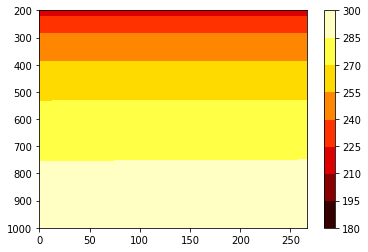

In [27]:
plt.contourf(distance[:-1],T_sm.lev,T_bin.T,cmap='hot')
plt.colorbar()
plt.ylim([1000,200])

(1000.0, 200.0)

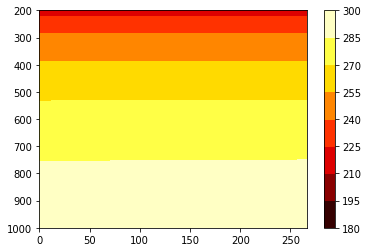

In [28]:
plt.contourf(distance[:-1],T_sm.lev,Tv_bin.T,cmap='hot')
plt.colorbar()
plt.ylim([1000,200])

In [29]:
%%time
# T by radius from cwv max (12/22/2021)

def write_data(t): ## Horizontal cwv gradient 
    data_sub1 = subset_MERRA2(MERRA2_3d_dir
                         ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
 
    q_sm = data_sub1.QV
    T_sm = data_sub1.T
    Tv_sm = T_sm + 0.61*q_sm # virtual temperature
    
    cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
    cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
    distance = np.linspace(0,300,10)
    geo_lat,geo_lon = np.meshgrid(cwv_sm.lat.values,cwv_sm.lon.values, indexing='ij')
    lat_idx, lon_idx = np.where(cwv_sm[16,:,:] == cwv_sm[16,:,:].max())
    dist_array = ((geo_lon-cwv_sm.lon.values[lon_idx[0]])**2 + (geo_lat-cwv_sm.lat.values[lat_idx[0]])**2)**0.5

    T_bin = np.zeros((len(distance)-1,len(T_sm.lev)))*np.nan
    Tv_bin = np.copy(T_bin)
    cwv_bin = np.zeros(len(distance)-1)

    for i in range(len(distance)-1):
        idx = np.where(np.logical_and(100*dist_array.ravel() >= distance[i], 
                                      100*dist_array.ravel() < distance[i+1]))[0]
        T_bin[i,:] = np.nanmean(T_sm.values[16,:,:,:].reshape(42,99)[:,idx],axis=1)
        Tv_bin[i,:] = np.nanmean(Tv_sm.values[16,:,:,:].reshape(42,99)[:,idx],axis=1)
        cwv_bin[i] =  np.nanmean(cwv_sm[16,:,:].values.ravel()[idx])
        
    print('time = ',t)

    return T_bin,Tv_bin,cwv_bin

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(1000), chunksize=500)
    pool.close()

time =  0
time =  1
time =  500
time =  501
time =  2
time =  502
time =  3
time =  503
time =  4
time =  504
time =  5
time =  505
time =  506
time =  6
time =  507
time =  7
time =  508
time =  8
time =  509
time =  9
time =  10
time =  510
time =  511
time =  11
time =  512
time =  12
time =  513
time =  13
time =  14
time =  514
time =  15
time =  515
time =  516
time =  16
time =  17
time =  517
time =  18
time =  518
time =  19
time =  519
time =  520
time =  20
time =  21
time =  521
time =  22
time =  522
time =  523
time =  23
time =  524
time =  24
time =  25
time =  525
time =  26
time =  526
time =  527
time =  27
time =  528
time =  28
time =  29
time =  529
time =  30
time =  530
time =  31
time =  531
time =  32
time =  532
time =  33
time =  533
time =  34
time =  534
time =  35
time =  535
time =  36
time =  37
time =  536
time =  38
time =  537
time =  39
time =  538
time =  40
time =  41
time =  539
time =  42
time =  540
time =  541
time =  43
time =  542
time =  44

time =  890
time =  301
time =  891
time =  302
time =  892
time =  303
time =  304
time =  893
time =  894
time =  305
time =  895
time =  896
time =  306
time =  897
time =  307
time =  308
time =  898
time =  309
time =  899
time =  900
time =  310
time =  311
time =  312
time =  901
time =  313
time =  902
time =  903
time =  904
time =  314
time =  315
time =  316
time =  317
time =  318
time =  905
time =  906
time =  907
time =  908
time =  319
time =  320
time =  321
time =  322
time =  323
time =  324
time =  325
time =  909
time =  326
time =  327
time =  328
time =  329
time =  910
time =  911
time =  912
time =  913
time =  914
time =  330
time =  331
time =  332
time =  915
time =  916
time =  917
time =  918
time =  333
time =  919
time =  334
time =  920
time =  335
time = time =   336921

time =  922
time =  337
time =  923
time =  338
time =  924
time =  339
time =  925
time =  340
time =  341
time =  926
time =  927
time =  342
time =  928
time =  343
time =  929
time

In [36]:
T_bin_all = np.zeros((1000,9,42))
Tv_bin_all = np.copy(T_bin_all)
cwv_bin_all = np.zeros((1000,9))

for n in range(1000):
    T_bin_all[n,:] = time_result[n][0]
    Tv_bin_all[n,:] = time_result[n][1]
    cwv_bin_all[n,:] = time_result[n][2]

(1000.0, 100.0)

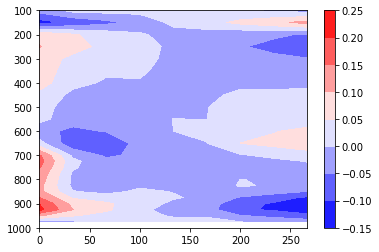

In [55]:
Tv_mean = np.tile(Tv_bin_all.mean(axis=(0,1)),(9,1)).swapaxes(0,1)
plt.contourf(distance[:-1],T_sm.lev,Tv_bin_all.mean(axis=0).T-Tv_mean,cmap='bwr',)
plt.colorbar()
plt.ylim([1000,100])

(1000.0, 100.0)

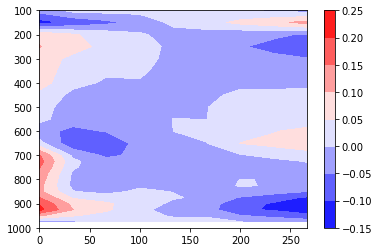

In [56]:
T_mean = np.tile(T_bin_all.mean(axis=(0,1)),(9,1)).swapaxes(0,1)
plt.contourf(distance[:-1],T_sm.lev,T_bin_all.mean(axis=0).T-T_mean,cmap='bwr')
plt.colorbar()
plt.ylim([1000,100])

Text(0.5, 0, 'distance [km]')

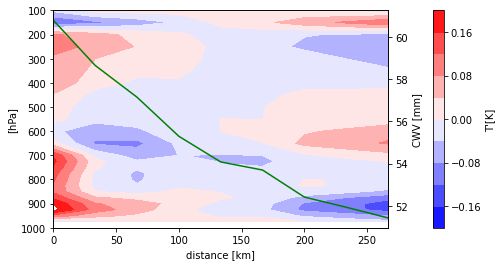

In [76]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

T_mean = np.tile(T_bin_all.mean(axis=(0,1)),(9,1)).swapaxes(0,1)

cf=ax.contourf(distance[:-1],T_sm.lev,T_bin_all.mean(axis=0).T-T_mean,cmap='bwr'
                  ,levels=np.linspace(-0.2,0.2,11))
cbar = plt.colorbar(cf,ax=ax,pad=0.1)
cbar.set_label("T'[K]")
ax.set_ylim([1000,100])
ax2 = ax.twinx()
ax2.plot(distance[:-1],cwv_bin_all.mean(axis=0),color='g')

ax2.set_ylabel('CWV [mm]')
ax.set_ylabel('[hPa]')
ax.set_xlabel('distance [km]')

In [ ]:
%%time
def write_data(t): # gross moist stability

        data_sub3 = subset_MERRA2(MERRA2_3d_dir+'../geoheight_3hr/'
                         ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
        
        z_sm = data_sub3.H
        lev = z_sm.lev
    
        z_org = np.nanmean(z_sm,axis=(2,3))
        vint_gz = np.trapz(z_org,lev*100,axis=1)

        return (vint_gz)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
vint_gz_org = np.zeros((len(t_org),33))

for n in range(len(t_org)):
    tmp = len(time_result[n])
    vint_gz_org[n,:tmp] = time_result[n]

os.chdir('/data/willytsai/ISCCP')
np.save('vint_gz_5deg_4ds.mat.npy',vint_gz_org)

In [ ]:
%%time 
# 2021 07/14 back!
def write_data(t): ## Horizontal cwv gradient 

    cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
    cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
    cwv_std = np.std(cwv_sm,axis=(1,2))
    cwv_gradx = np.abs(np.gradient(cwv_sm,cwv_sm.lon*1000*100,axis=2))
    cwv_grady = np.abs(np.gradient(cwv_sm,cwv_sm.lat*1000*100,axis=1))
    
    # cwv_grad binned by deviation from the mean
    deviate_cwv = np.arange(-10,10)
    cwv_deviate = cwv_sm[16,:,:] - cwv_sm[16,:,:].mean() # deviation from the mean at P_ref

    dev_bin = np.zeros(len(deviate_cwv)-1)*np.nan
    for i in range(len(deviate_cwv)-1):
        idx = np.where(np.logical_and(cwv_deviate.values.ravel() >= deviate_cwv[i]
                                      , cwv_deviate.values.ravel()< deviate_cwv[i+1]))[0]
        dev_bin[i] = np.mean(1/2*(cwv_gradx[16,:,:].ravel()[idx]+cwv_grady[16,:,:].ravel()[idx]))
    
    return cwv_std.values, dev_bin

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
time_resultsult[0][0]

In [ ]:
cwv_std_org = np.zeros((len(t_org),33))
deviate_cwv = np.arange(-10,10)
cwv_grad_org = np.zeros((len(t_org),len(deviate_cwv)-1))

for n in range(len(t_org)):
    cwv_std_org[n,:] = time_result[n][0]
    cwv_grad_org[n] = time_result[n][1]

os.chdir('/data/willytsai/ISCCP')
np.save('cwv_std_5deg_4ds.mat.npy',cwv_std_org)
np.save('cwv_gradbin_5deg_4ds.mat.npy',cwv_grad_org)

In [ ]:
%%time
# cwv gradient by radius from cwv max 

def write_data(t): ## Horizontal cwv gradient 
    
    cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
    cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
    cwv_gradx = np.gradient(cwv_sm,cwv_sm.lon*1000*100,axis=2)
    cwv_grady = np.gradient(cwv_sm,cwv_sm.lat*1000*100,axis=1)

    # gradient binned by distance from CWVmax
    cwv_grad = (cwv_gradx[16,:,:]*cwv_grady[16,:,:])**(1/2) # geometric mean of cwv gradient 
    distance = np.linspace(0,300,10)
    geo_lat,geo_lon = np.meshgrid(cwv_sm.lat.values,cwv_sm.lon.values, indexing='ij')
    lat_idx, lon_idx = np.where(cwv_sm[16,:,:] == cwv_sm[16,:,:].max())
    dist_array = ((geo_lon-cwv_sm.lon.values[lon_idx[0]])**2 + (geo_lat-cwv_sm.lat.values[lat_idx[0]])**2)**0.5

    cwv_gradbin = np.zeros(len(distance)-1)*np.nan

    for i in range(len(distance)-1):
        idx = np.where(np.logical_and(100*dist_array.ravel() >= distance[i], 
                                      100*dist_array.ravel() < distance[i+1]))[0]
        cwv_gradbin[i] = np.nanmean(cwv_grad.ravel()[idx])

    return cwv_gradbin

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
cwv_grad_org = np.zeros((len(t_org),9))*np.nan

for n in range(len(t_org)):
    cwv_grad_org[n,:] = time_result[n]

os.chdir('/data/willytsai/ISCCP')
np.save('cwv_gradbin_dist_5deg_4ds.mat.npy',cwv_grad_org)

In [ ]:
t=2

cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
cwv_gradx = np.gradient(cwv_sm,cwv_sm.lon*1000*100,axis=2)
cwv_grady = np.gradient(cwv_sm,cwv_sm.lat*1000*100,axis=1)

# gradient binned by distance from CWVmax
cwv_grad = (cwv_gradx[16,:,:]*cwv_grady[16,:,:])**(1/2) # geometric mean of cwv gradient 
distance = np.linspace(0,300,10)
geo_lat,geo_lon = np.meshgrid(cwv_sm.lat.values,cwv_sm.lon.values, indexing='ij')
lat_idx, lon_idx = np.where(cwv_sm[16,:,:] == cwv_sm[16,:,:].max())
dist_array = ((geo_lon-cwv_sm.lon.values[lon_idx[0]])**2 + (geo_lat-cwv_sm.lat.values[lat_idx[0]])**2)**0.5

cwv_gradbin = np.zeros(len(distance)-1)*np.nan

for i in range(len(distance)-1):
    idx = np.where(np.logical_and(100*dist_array.ravel() >= distance[i], 
                                  100*dist_array.ravel() < distance[i+1]))[0]
    cwv_gradbin[i] = np.nanmean(cwv_grad.ravel()[idx])


In [ ]:
plt.contour(dist_array,level=10)
plt.contourf(cwv_sm[16,:,:],levels=20)
cbar = plt.colorbar()
cbar.set_label('CWV [mm]')

In [ ]:
cwv_gradbin = np.zeros(len(distance)-1)*np.nan

for i in range(len(distance)-1):
    idx = np.where(np.logical_and(100*dist_array.ravel() >= distance[i], 100*dist_array.ravel() < distance[i+1]))[0]
    cwv_gradbin[i] = np.nanmean(cwv_grad.ravel()[idx])

In [ ]:
plt.plot(distance[1:],cwv_gradbin)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_TRMM(TRMM_dir+'2009_2018'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=5,lon_inc=5)
#     prec_sm = data_sub.precipitation
#     prec_org = np.nanmean(prec_sm,axis=(1,2))
    
#     return (prec_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# prec_org = np.zeros((len(t_org),33))

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     if tmp ==33:
#         prec_org[n,:tmp] = time_result[n]
#     else:
#         prec_org[n,:tmp] = np.nan

# os.chdir('/data/willytsai/ISCCP')
# np.save('prec_all_10deg_4ds.mat.npy',prec_org)

In [ ]:
# ## testing bed for precM2 vs. TRMM, cwvM2 vs. AIRS

# d = 2.5

# t=4200

# # cwv
# data_sub = subset_AIRS(AIRS_dir
#                     ,time_event[t],lat_event[t],lon_event[t],days=2,
#                     lat_inc=d,lon_inc=d)
# cwv_A = data_sub.TotH2OVap_A.mean(axis=(1,2))
# cwv_D = data_sub.TotH2OVap_D.mean(axis=(1,2))
# cwv_airs = np.array([cwv_A,cwv_D])
# cwv_airs = np.nanmean(cwv_airs,0)

# data_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                     ,time_event[t],lat_event[t],lon_event[t],days=2,
#                     lat_inc=d,lon_inc=d)
# cwv_sm2 = data_sub.TQV.resample(time='3H').nearest()
# cwv_M2 = np.nanmean(cwv_sm2,axis=(1,2))

# # precip
# data_sub = subset_TRMM(TRMM_dir+'2009_2018'
#                     ,time_event[t],lat_event[t],lon_event[t],days=2,
#                     lat_inc=d,lon_inc=d)
# prec_sm = data_sub.precipitation
# prec_org = np.nanmean(24*prec_sm,axis=(1,2))

# data_sub7 = subset_MERRA2(MERRA2_3d_dir+'../Preci_3hr'
#                         ,time_event[t],lat_event[t],lon_event[t],days=2,
#                         lat_inc=d,lon_inc=d)
# precM2_sm = data_sub7.PRECTOT.resample(time='3H').nearest()   
# precM2_org = np.nanmean(24*3600*precM2_sm,axis=(1,2))

# fig,ax = plt.subplots(1,2,figsize=(12,5))
# ax[0].plot(prec_sm.time,prec_org,'-ok',label='TRMM')
# ax[0].plot(precM2_sm.time,precM2_org,'--or',label='MERRA-2')
# ax[0].legend()
# #ax[0].set_ylim([0,30])

# ax[1].plot(cwv_D.time.values,cwv_airs,'-ok',label='AIRS')
# ax[1].plot(cwv_sm2.time.values,cwv_M2,'--or',label='MERRA-2')
# ax[1].legend()
# #ax[0].set_ylim([0,30])
# #ax[1].set_ylim([0,30])


In [ ]:
%%time
def write_data(t):
    
    data_sub7 = subset_MERRA2(MERRA2_dir+'/tavg_2d_ANA'
                        ,time_event[t],lat_event[t],lon_event[t],days=2,
                        lat_inc=2.5,lon_inc=2.5)

    dh_ana_sm = data_sub7.DHDT_ANA.resample(time='3H').nearest() # MERRA2 analysis tendency of CpT
    dq_ana_sm = data_sub7.DQVDT_ANA.resample(time='3H').nearest() # MERRA2 analysis tendecny of q  
    dh_phy_sm = data_sub7.DHDT_PHY.resample(time='3H').nearest() # MERRA2 physics tendency of CpT
    dq_phy_sm = data_sub7.DQVDT_PHY.resample(time='3H').nearest() # MERRA2 physics tendecny of q      
    dh_dyn_sm = data_sub7.DHDT_DYN.resample(time='3H').nearest() # MERRA2 dynamics tendency of CpT
    dq_dyn_sm = data_sub7.DQVDT_DYN.resample(time='3H').nearest() # MERRA2 dynamics tendecny of q  
    
    
    dh_ana_org = np.nanmean(dh_ana_sm,axis=(1,2))
    dq_ana_org = np.nanmean(dq_ana_sm,axis=(1,2))
    dh_phy_org = np.nanmean(dh_phy_sm,axis=(1,2))
    dq_phy_org = np.nanmean(dq_phy_sm,axis=(1,2))
    dh_dyn_org = np.nanmean(dh_dyn_sm,axis=(1,2))
    dq_dyn_org = np.nanmean(dq_dyn_sm,axis=(1,2))
    
    return (dh_ana_org,dh_phy_org,dh_dyn_org,dq_ana_org,dq_phy_org,dq_dyn_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
dh_ana_org = np.zeros((len(t_org),32))
dh_phy_org = np.zeros((len(t_org),32))
dh_dyn_org = np.zeros((len(t_org),32))

dq_ana_org = np.zeros((len(t_org),32))
dq_phy_org = np.zeros((len(t_org),32))
dq_dyn_org = np.zeros((len(t_org),32))

for n in range(len(t_org)):
    tmp = len(time_result[n][0])
    dh_ana_org[n,:tmp] = time_result[n][0]
    dh_phy_org[n,:tmp] = time_result[n][1]
    dh_dyn_org[n,:tmp] = time_result[n][2]
    
    dq_ana_org[n,:tmp] = time_result[n][3]
    dq_phy_org[n,:tmp] = time_result[n][4]
    dq_dyn_org[n,:tmp] = time_result[n][5]

os.chdir('/data/willytsai/ISCCP')
np.save('DHDT_ANA_all_5deg_4ds.mat.npy',dh_ana_org)
np.save('DHDT_PHY_all_5deg_4ds.mat.npy',dh_phy_org)
np.save('DHDT_DYN_all_5deg_4ds.mat.npy',dh_dyn_org)

np.save('DQVDT_ANA_all_5deg_4ds.mat.npy',dq_ana_org)
np.save('DQVDT_PHY_all_5deg_4ds.mat.npy',dq_phy_org)
np.save('DQVDT_DYN_all_5deg_4ds.mat.npy',dq_dyn_org)

In [ ]:
%%time
def write_data(t):
    
    data_sub7 = subset_MERRA2(MERRA2_3d_dir+'../Preci_3hr'
                        ,time_event[t],lat_event[t],lon_event[t],days=2,
                        lat_inc=5,lon_inc=5)

    precM2_sm = data_sub7.PRECTOT.resample(time='3H').nearest()   
    precM2_org = np.nanmean(precM2_sm,axis=(1,2))
    
    return (precM2_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
precM2_org = np.zeros((len(t_org),32))

for n in range(len(t_org)):
    tmp = len(time_result[n])
    precM2_org[n,:tmp] = time_result[n]

os.chdir('/data/willytsai/ISCCP')
np.save('precM2_all_10deg_4ds.mat.npy',precM2_org)

In [ ]:
%%time
def write_data(t):

    bt_sub = subset_gridsat(Gridsat_dir+'2009_2018',time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=5,lon_inc=5)
    bt_sm = bt_sub.irwin_cdr
    SCAI_BT,N_psT = SCAI_index_bt(bt_sm,cri_val=240)
    cldfrac_sm = [len(np.where(bt_sm[n,:,:] < 240)[0])/(len(bt_sm.lat)*len(bt_sm.lon)) for n in range(33)]
#    bt_org = bt_sm.mean(axis=(1,2))
    
    return SCAI_BT, N_psT, cldfrac_sm

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
SCAI_org = np.zeros((len(t_org),33))
N_org = np.zeros((len(t_org),33))
cldfrac_org = np.zeros((len(t_org),33))

for n in range(len(t_org)):
    tmp = len(time_result[n][0])
    SCAI_org[n,:tmp] = time_result[n][0]
    N_org[n,:tmp] = time_result[n][1]
    cldfrac_org[n,:tmp] = np.asarray(time_result[n][2])

os.chdir('/data/willytsai/ISCCP')
np.save('SCAIbt_all_10deg_4ds_qd.mat.npy',SCAI_org)
np.save('N_all_10deg_4ds_qd.mat.npy',N_org)
np.save('cldfrac_all_10deg_4ds_qd.mat.npy',cldfrac_org)

In [ ]:
# %%time
# def write_data(t):

#     rh_sub = subset_MERRA2('/data/willytsai/RH_3hr_p',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     rh_sm = rh_sub.RH.values
#     rh = np.nanmean(rh_sm,axis=(2,3))
    
#     return (rh)
    
# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# rh_org = np.zeros((len(t_org),33,42))*np.nan
# for n in range(len(t_org)):
#     tmp = time_result[n].shape[0]
#     rh_org[n,:tmp,:] = time_result[n]
    
# os.chdir('/data/willytsai/ISCCP')
# np.save('rh_all_5deg_4ds_qd.mat.npy',rh_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_CERES('/data/willytsai/CERES/'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     swup_toa = np.nanmean(data_sub.adj_atmos_sw_up_all_toa_3h,axis=(1,2))
#     swup_sfc = np.nanmean(data_sub.adj_atmos_sw_up_all_surface_3h,axis=(1,2))
#     swdown_toa = np.nanmean(data_sub.adj_atmos_sw_down_all_toa_3h,axis=(1,2))
#     swdown_sfc = np.nanmean(data_sub.adj_atmos_sw_down_all_surface_3h,axis=(1,2))
#     lwup_toa = np.nanmean(data_sub.adj_atmos_lw_up_all_toa_3h,axis=(1,2))        
#     lwup_sfc = np.nanmean(data_sub.adj_atmos_lw_up_all_surface_3h,axis=(1,2))  
#     lwdown_toa = np.nanmean(data_sub.adj_atmos_lw_down_all_toa_3h,axis=(1,2))      
#     lwdown_sfc = np.nanmean(data_sub.adj_atmos_lw_down_all_surface_3h,axis=(1,2))  

#     # net atmosphere radiation 
#     qr_net_ce = (swdown_toa-swup_toa)+(lwdown_toa-lwup_toa) + (lwup_sfc-lwdown_sfc)+(swup_sfc-swdown_sfc)

#     return (qr_net_ce, lwup_toa)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# qr_org = np.zeros((len(t_org),32))*np.nan
# lwup_org = np.zeros((len(t_org),32))*np.nan

# for n in range(len(t_org)):
#     tmp = len(time_result[n][0])
#     qr_org[n,:tmp] = time_result[n][0]
#     lwup_org[n,:tmp] = time_result[n][1]

# os.chdir('/data/willytsai/ISCCP')
# np.save('QR_CERES_all_5deg_4ds_qd.mat.npy',qr_org)
# np.save('lwtoa_CERES_all_5deg_4ds_qd.mat.npy',lwup_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_MERRA2(MERRA2_dir+'inst2d_SFLX'
#                         ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=2.5,lon_inc=2.5)
 
#     lhf_sm = data_sub.EVAP.resample(time='3H').nearest()   
#     shf_sm = data_sub.HFLUX.resample(time='3H').nearest()
#     lon = lhf_sm.lon
#     lat = lhf_sm.lat
    
#     lhf_org = np.nanmean(lhf_sm,axis=(1,2))*2.5E6
#     shf_org = np.nanmean(shf_sm,axis=(1,2))

#     return (lhf_org, shf_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# lhf_org = np.zeros((len(t_org),32))
# shf_org = np.zeros((len(t_org),32))

# for n in range(len(t_org)):
#     tmp = time_result[n][0].shape[0]
#     lhf_org[n,:tmp] = time_result[n][0]
#     shf_org[n,:tmp] = time_result[n][1]

# os.chdir('/data/willytsai/ISCCP')
# np.save('LHF_all_lat_5deg_4ds_qd.mat.npy',lhf_org)
# np.save('SHF_all_lat_5deg_4ds_qd.mat.npy',shf_org)

In [ ]:
# %%time
# def write_data(t):
        
#     try:
#         ctp_sub = subset_ISCCP_pc(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
        
#         ctp_org = np.zeros(33)
#         for n in range(33):
#             tmp = ctp_sub[n,:,:].values.flatten()
#             tmp[tmp<0] = np.nan
#             ctp_org[n] = np.nanmean(tmp) # mean ctp
        
#     except:
#         ctp_org = np.zeros(33)*np.nan # if not detected, set zero
    
#     return ctp_org

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(0,60000), chunksize=500)
#     pool.close()

In [ ]:
# %%time
# def write_data(t):
        
#     try:
#         ctp_sub = subset_ISCCP_pc(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
        
#         ctp_bins = np.linspace(100,900,21)
#         ctp_dist = np.zeros((33,len(ctp_bins)-1))
#         for tt in range(33):
#             ctp_sm = ctp_sub[tt,:,:].values.flatten()
#             for i in range(len(ctp_bins)-1):
#                 idx = np.where(np.logical_and(ctp_sm>=ctp_bins[i], ctp_sm<ctp_bins[i+1]))[0]
#                 ctp_dist[tt,i] += len(idx)               
        
#     except:
#         ctp_bins = np.linspace(100,900,21)
#         ctp_dist = np.zeros((33,len(ctp_bins)-1)) # if not detected, set zero
    
#     return ctp_dist

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(120000,180000), chunksize=500)
#     pool.close()

In [ ]:
#ctp_dist_org = np.zeros((len(t_org),33,20))

In [ ]:
# t_str = 60000
# for n in range(len(time_result)):
#     tmp = time_result[n].shape[0]
#     ctp_dist_org[n+t_str,:tmp,:] = time_result[n]

In [ ]:
# ctp_dist_org[120000,:,:]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('ctp_dist_all_5deg_4ds.mat.npy',ctp_org)

### ---------

In [ ]:
%%time
# CWV tendency derived from CWV of 2d, 5d, 10d running mean
def write_data(t):
    try:
        cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=15,
                          lat_inc=2.5,lon_inc=2.5)
        cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
        cwv_36hrm = running_mean(cwv_sm.mean(axis=(1,2)),12) # 2d-running mean

        cwv_36hdt = 24*np.gradient(cwv_36hrm,3)[120-16:120+17]

    except:
        cwv_36hdt = np.nan*np.zeros(33)

    return cwv_36hdt

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
%%time
# CWV tendency derived from CWV of 2d, 5d, 10d running mean
def write_data(t):
    try:
        cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
                          ,time_event[t],lat_event[t],lon_event[t],days=15,
                          lat_inc=2.5,lon_inc=2.5)
        cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
        cwv_36hrm = running_mean(cwv_sm.mean(axis=(1,2)),12) # 2d-running mean

#         cwv_2ddt = 24*np.gradient(cwv_2drm,3)[120-16:120+17]
#         cwv_5ddt = 24*np.gradient(cwv_5drm,3)[120-16:120+17]
#         cwv_10ddt = 24*np.gradient(cwv_10drm,3)[120-16:120+17]
        cwv_36hrm = cwv_36hrm[120-16:120+17]

    except:
        cwv_36hrm = np.nan*np.zeros(33)
#         cwv_5ddt = np.nan*np.zeros(33)
#         cwv_10ddt = np.nan*np.zeros(33)

    return cwv_36hrm

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
cwv_36horg = np.zeros((len(t_org),33))

for n in range(len(t_org)):
    cwv_36horg[n,:] = time_result[n]
    
os.chdir('/data/willytsai/ISCCP')
np.save('cwv_36hrm_all_5deg_4ds.mat.npy',cwv_36horg)

In [ ]:
# ##### required for WHOI surface flux data output #######
# os.chdir('/data/willytsai/WHOI_oaflux/')
# data = xr.open_dataset('evapr_oaflux_2014_2018.nc')

# date = []; date_begin = datetime(2014,1,1)
# for t in range(1826):
#     tmp = date_begin + t*timedelta(days=1)
#     date.append(tmp)

# evap_xr = xr.DataArray(data.evapr.values,coords=[date,data.lat,data.lon],dims=['time','lat','lon'])

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_WHOI(WHOI_dir, time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     evap_org = data_sub.values.mean(axis=(1,2))

#     return (evap_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# evap_org = np.zeros((len(t_org),5))*np.nan

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     evap_org[n,:tmp] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('LHF_WHOI_all_5deg_4ds.mat.npy',evap_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_CERES('/data/willytsai/CERES/'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     swup_toa = np.nanmean(data_sub.adj_atmos_sw_up_all_toa_3h,axis=(1,2))
#     swup_sfc = np.nanmean(data_sub.adj_atmos_sw_up_all_surface_3h,axis=(1,2))
#     swdown_toa = np.nanmean(data_sub.adj_atmos_sw_down_all_toa_3h,axis=(1,2))
#     swdown_sfc = np.nanmean(data_sub.adj_atmos_sw_down_all_surface_3h,axis=(1,2))
#     lwup_toa = np.nanmean(data_sub.adj_atmos_lw_up_all_toa_3h,axis=(1,2))        
#     lwup_sfc = np.nanmean(data_sub.adj_atmos_lw_up_all_surface_3h,axis=(1,2))  
#     lwdown_toa = np.nanmean(data_sub.adj_atmos_lw_down_all_toa_3h,axis=(1,2))      
#     lwdown_sfc = np.nanmean(data_sub.adj_atmos_lw_down_all_surface_3h,axis=(1,2))  

#     # net atmosphere radiation 
#     qr_net_ce = (swdown_toa-swup_toa)+(lwdown_toa-lwup_toa) + (lwup_sfc-lwdown_sfc)+(swup_sfc-swdown_sfc)

#     return (qr_net_ce, lwup_toa)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# qr_org = np.zeros((len(t_org),32))*np.nan
# lwup_org = np.zeros((len(t_org),32))*np.nan

# for n in range(len(t_org)):
#     tmp = len(time_result[n][0])
#     qr_org[n,:tmp] = time_result[n][0]
#     lwup_org[n,:tmp] = time_result[n][1]

# os.chdir('/data/willytsai/ISCCP')
# np.save('QR_CERES_all_5deg_4ds.mat.npy',qr_org)
# np.save('lwtoa_CERES_all_5deg_4ds.mat.npy',lwup_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     prec_sm = data_sub2.precipitation
#     prec_bins = np.linspace(0,60,31)
#     prec_dist = np.zeros((33,len(prec_bins)-1))
    
#     for tt in range(33):
#         prec_1d = prec_sm[tt,:,:].values.flatten()

#         for i in range(len(prec_bins)-1):
#             idx = np.where(np.logical_and(prec_1d>=prec_bins[i],prec_1d<prec_bins[i+1]))[0]
#             prec_dist[tt,i] += len(idx)

# #    prec_org = np.nanmean(prec_sm,axis=(1,2))
# #    prec_trim = running_mean(prec_org,8)
# #    prec_trim = prec_trim[8:-8]
#     return (prec_dist)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# precdist_org = np.zeros((len(t_org),33,31))

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     precdist_org[n,:tmp,:] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('precdist_all_5deg_4ds.mat.npy',prec_org)

In [ ]:
# precdist_org = np.zeros((len(t_org),33,30))

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     precdist_org[n,:tmp,:] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('precdist_all_5deg_4ds_1DRM.mat.npy',precdist_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_MERRA2('/data/willytsai/Rad_new_hrly/'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     lwtoa_sm = data_sub.LWTUP.resample(time='3H').nearest()
#     swtoa_sm = data_sub.SWTNT.resample(time='3H').nearest()
#     lwgnt_sm = data_sub.LWGNT.resample(time='3H').nearest()
#     swgnt_sm = data_sub.SWGNT.resample(time='3H').nearest()
        
#     lwtoa_org = np.nanmean(lwtoa_sm,axis=(1,2))
#     swtoa_org = np.nanmean(swtoa_sm,axis=(1,2))
#     lwgnt_org = np.nanmean(lwgnt_sm,axis=(1,2))
#     swgnt_org = np.nanmean(swgnt_sm,axis=(1,2))

#     return (lwtoa_org, swtoa_org, lwgnt_org, swgnt_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# lwtoa_org = np.zeros((len(t_org),32))
# swtoa_org = np.zeros((len(t_org),32))
# lwgnt_org = np.zeros((len(t_org),32))
# swgnt_org = np.zeros((len(t_org),32))

# for n in range(len(t_org)):
#     tmp = len(time_result[n][0])
#     lwtoa_org[n,:tmp] = time_result[n][0]
#     swtoa_org[n,:tmp] = time_result[n][1]
#     lwgnt_org[n,:tmp] = time_result[n][2]
#     swgnt_org[n,:tmp] = time_result[n][3]
    
# os.chdir('/data/willytsai/ISCCP')
# np.save('lwtoa_all_5deg_4ds_1DRM.mat.npy',lwtoa_org)
# np.save('swtoa_all_5deg_4ds_1DRM.mat.npy',swtoa_org)
# np.save('lwgnt_all_5deg_4ds_1DRM.mat.npy',lwgnt_org)
# np.save('swgnt_all_5deg_4ds_1DRM.mat.npy',swgnt_org)

In [ ]:
%%time
def write_data(t): # gross moist stability
    
        data_sub = subset_MERRA2(MERRA2_3d_dir
                               ,time_event[t],lat_event[t],lon_event[t],days=2,lon_inc=2.5,lat_inc=2.5)
#         data_sub2 = subset_MERRA2(MERRA2_3d_dir+'../omega_3hr'
#                          ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
        data_sub3 = subset_MERRA2(MERRA2_3d_dir+'../geoheight_3hr/'
                         ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=2.5,lon_inc=2.5)
        
        u_sm = data_sub.U
        v_sm = data_sub.V
        T_sm = data_sub.T
#         omega_sm = data_sub2.OMEGA
        q_sm = data_sub.QV
        z_sm = data_sub3.H
        lev = T_sm.lev
        lon = T_sm.lon
        lat = T_sm.lat
                
        h_sm = 1004*T_sm + 2.5e6*q_sm + 9.8*z_sm 
        s_sm = 1004*T_sm + 9.8*z_sm 
    
#        hadv_sm = u_sm*np.gradient(h_sm,lon*100000,axis=3) + v_sm*np.gradient(h_sm,lat*100000,axis=2)
#        sadv_sm = u_sm*np.gradient(s_sm,lon*100000,axis=3) + v_sm*np.gradient(s_sm,lat*100000,axis=2)
        
        dhdx = np.nanmean(np.gradient(h_sm,lon*100000,axis=3),axis=(2,3))
        dhdy = np.nanmean(np.gradient(h_sm,lat*100000,axis=2),axis=(2,3))
        hadv_org = u_sm.mean(axis=(2,3))*dhdx + v_sm.mean(axis=(2,3))*dhdy
        
        dsdx = np.nanmean(np.gradient(s_sm,lon*100000,axis=3),axis=(2,3))
        dsdy = np.nanmean(np.gradient(s_sm,lat*100000,axis=2),axis=(2,3))
        sadv_org = u_sm.mean(axis=(2,3))*dsdx + v_sm.mean(axis=(2,3))*dsdy
    
#         hflux_org = np.nanmean(hflux_sm,axis=(2,3))
#         sflux_org = np.nanmean(sflux_sm,axis=(2,3))

        return (hadv_org, sadv_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
hadv_org = np.zeros((len(t_org),33,42))
sadv_org = np.zeros((len(t_org),33,42))

for n in range(len(t_org)):
    tmp = len(time_result[n][0])
    hadv_org[n,:tmp,:] = time_result[n][0]
    sadv_org[n,:tmp,:] = time_result[n][1]
    
os.chdir('/data/willytsai/ISCCP')
np.save('hadv_mn_all_5deg_4ds.mat.npy',hadv_org)
np.save('sadv_mn_all_5deg_4ds.mat.npy',sadv_org)

In [ ]:
# %%time
# def write_data(t): # gross moist stability
    
#         data_sub = subset_MERRA2(MERRA2_3d_dir
#                                ,time_event[t],lat_event[t],lon_event[t],days=2,lon_inc=2.5,lat_inc=2.5)
# #         data_sub2 = subset_MERRA2(MERRA2_3d_dir+'../omega_3hr'
# #                          ,time_event[t],lat_event[t],lon_event[t],days=2,
# #                           lat_inc=2.5,lon_inc=2.5)
#         data_sub3 = subset_MERRA2(MERRA2_3d_dir+'../geoheight_3hr/'
#                          ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
        
# #         u_sm = data_sub.U
# #         v_sm = data_sub.V
#         T_sm = data_sub.T
# #         omega_sm = data_sub2.OMEGA
#         q_sm = data_sub.QV
#         z_sm = data_sub3.H
#         lev = T_sm.lev
#         lon = T_sm.lon
#         lat = T_sm.lat
                
#         h_sm = 1004*T_sm + 2.5e6*q_sm + 9.8*z_sm 
#         s_sm = 1004*T_sm + 9.8*z_sm 
    
# #         hflux_sm = np.gradient(h_sm*u_sm,lon*100000,axis=3) +  \
# #                   np.gradient(h_sm*v_sm,lat*100000,axis=2) + np.gradient(h_sm*omega_sm,lev*100,axis=1)
# #         sflux_sm = np.gradient(s_sm*u_sm,lon*100000,axis=3) +  \
# #                   np.gradient(s_sm*v_sm,lat*100000,axis=2) + np.gradient(s_sm*omega_sm,lev*100,axis=1)
    
# #         hflux_org = np.nanmean(hflux_sm,axis=(2,3))
# #         sflux_org = np.nanmean(sflux_sm,axis=(2,3))
#         h_org = np.nanmean(h_sm,axis=(2,3))
#         s_org = np.nanmean(s_sm,axis=(2,3))

#         return (h_org, s_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# s_org = np.zeros((len(t_org),33,42))
# h_org = np.zeros((len(t_org),33,42))

# for n in range(len(t_org)):
#     tmp = len(time_result[n][0])
#     h_org[n,:tmp,:] = time_result[n][0]
#     s_org[n,:tmp,:] = time_result[n][1]

# os.chdir('/data/willytsai/ISCCP')
# np.save('dse_all_5deg_4ds.mat.npy',s_org)
# np.save('mse_all_5deg_4ds.mat.npy',h_org)

In [ ]:
# %%time
# def write_data(t): 
    
#         data_sub = subset_MERRA2(MERRA2_3d_dir
#                                ,time_event[t],lat_event[t],lon_event[t],2,lon_inc=2.5,lat_inc=2.5)
#         u_sm = data_sub.U
#         v_sm = data_sub.V
#         lev = data_sub.lev
        
#         # Alexander and Young (1992), Weisman and Klemp (1982) definition of LLWS 
#         u_950 = u_sm.sel(lev=slice(1000,950)).mean(axis=(2,3))
#         u_950m = np.trapz(u_950,u_950.lev,axis=1)/(1000-950)
#         u_500 = u_sm.sel(lev=slice(1000,500)).mean(axis=(2,3))
#         u_500m = np.trapz(u_500,u_500.lev,axis=1)/(1000-500)

#         v_950 = v_sm.sel(lev=slice(1000,950)).mean(axis=(2,3))
#         v_950m = np.trapz(v_950,v_950.lev,axis=1)/(1000-950)
#         v_500 = v_sm.sel(lev=slice(1000,500)).mean(axis=(2,3))
#         v_500m = np.trapz(v_500,v_500.lev,axis=1)/(1000-500)

#         LLS_sm = 1/2 *( (u_500m - u_950m)**2 + (v_500m - v_950m)**2 )
#         #LLS_sm  = np.nanmean(LLS,axis=(1,2))
        
#         return LLS_sm

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# LLS_org = np.zeros((len(t_org),33))

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     LLS_org[n,:tmp] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('LLWS_all_5deg_4ds_1DRM.mat.npy',LLS_org)

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                             lat_inc=2.5,lon_inc=2.5)
    
#     prec_sm = data_sub2.precipitation
#     prec_std = np.nanmax(prec_sm,axis=(1,2))

#     return (prec_std)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# prec_std = np.zeros((len(t_org),33))

# for n in range(len(t_org)):
#     tmp = time_result[0].shape[0]
#     prec_std[n,:tmp] = time_result[n]

In [ ]:
# os.chdir('/data/willytsai/ISCCP/')
# np.save('precstd_all_5deg_4ds_1DRM.mat.npy',prec_std)

In [ ]:
# %%time
# def write_data(t):
    
#         data_sub = subset_MERRA2(MERRA2_3d_dir
#                                ,time_event[t],lat_event[t],lon_event[t],2,lon_inc=2.5,lat_inc=2.5)
#         u_sm = data_sub.U
#         v_sm = data_sub.V
#         lev = u_sm.lev
#         lon = u_sm.lon
#         lat = u_sm.lat
   
#         vort_sm = np.gradient(v_sm,lon*100000,axis=3) -  \
#                   np.gradient(u_sm,lat*100000,axis=2)
    
#         vort_org = np.nanmean(vort_sm,axis=(2,3))
        
#         return (vort_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# vort_org = np.zeros((len(time_result),33,42))*np.nan

# for n in range(len(time_result)):
#     tmp = len(time_result[n])
#     vort_org[n,:tmp,:] = time_result[n]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('vort_all_5deg_4ds_1DRM.mat.npy',vort_org)

In [ ]:
# %%time
# def write_data(t): ## Horizontal cwv gradient 

#     cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
#     cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
#     cwv_xgrad = np.abs(np.gradient(cwv_sm, cwv_sm.lon*100000, axis=2))
#     cwv_ygrad = np.abs(np.gradient(cwv_sm, cwv_sm.lat*100000, axis=1))

#     cwv_xmean = np.nanmean(cwv_xgrad,axis=(1,2))
#     cwv_ymean = np.nanmean(cwv_ygrad,axis=(1,2))

#     return cwv_xmean, cwv_ymean

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# cwvx_org = np.zeros((len(time_result),33))*np.nan
# cwvy_org = np.zeros((len(time_result),33))*np.nan

# for n in range(len(time_result)):
#     tmp = len(time_result[n][0])
#     cwvx_org[n,:tmp] = time_result[n][0]
#     cwvy_org[n,:tmp] = time_result[n][1]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('cwv_longrad_all_5deg_4ds_1DRM.mat.npy',cwvx_org)
# np.save('cwv_latgrad_all_5deg_4ds_1DRM.mat.npy',cwvy_org)

In [ ]:
# %%time
# def write_data(t):
#     data_sub1 = subset_MERRA2(MERRA2_3d_dir
#                          ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
 
#     q_sm = data_sub1.QV
#     T_sm = data_sub1.T
#     # cape and cin
#     p = T_sm.lev.values*units('mbar')
#     # cape/cin calculation
#     cape_sm = np.zeros(len(T_sm.time))
#     cin_sm = np.copy(cape_sm)
#     for t in range(len(T_sm.time)):
#         T_tmp = np.nanmean(T_sm[t,:,:,:],axis=(1,2))
#         q_tmp = np.nanmean(q_sm[t,:,:,:],axis=(1,2))
#         T = (T_tmp-273.15)*units('degC')
#         q = q_tmp*units('kg/kg')
#         Td = mpcalc.dewpoint(mpcalc.vapor_pressure(p,q))
        
#         try:
#             Tp = mpcalc.parcel_profile(p,T[0],Td[0]).to('degC')                    
#             el_pressure,el_temperature = mpcalc.el(p,T,Td) # equilibrium level
#             el_idx = np.argmin(np.abs(p.magnitude - el_pressure.magnitude))                
#             ELps = [el_pressure.magnitude] # Initialize an array of EL pressures for detrainment profile
#             [CAPE,CIN] = mpcalc.cape_cin(p[:el_idx],T[:el_idx],Td[:el_idx],Tp[:el_idx])
#             cape_sm[t] = CAPE.magnitude
#             cin_sm[t] = CIN.magnitude
#         except:
#             cape_sm[t] = np.nan
#             cin_sm[t] = np.nan


#     return cape_sm, cin_sm

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# cape_org = np.zeros((len(time_result),33))*np.nan
# cin_org = np.zeros((len(time_result),33))*np.nan

# for n in range(len(time_result)):
#     tmp = len(time_result[n][0])
#     cape_org[n,:tmp] = time_result[n][0]
#     cin_org[n,:tmp] = time_result[n][1]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('cape_all_5deg_4ds_1DRM.mat.npy',cape_org)
# np.save('cin_all_5deg_4ds_1DRM.mat.npyy',cin_org)

In [ ]:
# %%time
# def write_data(t):

#     bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     bt_sm = bt_sub.irwin_cdr
#     SCAI_BT,N_psT = SCAI_index_bt(bt_sm,cri_val=240)
#     cldfrac_sm = [len(np.where(bt_sm[n,:,:] < 240)[0])/(len(bt_sm.lat)*len(bt_sm.lon)) for n in range(33)]
# #    bt_org = bt_sm.mean(axis=(1,2))
    
#     return SCAI_BT, N_psT, cldfrac_sm

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# SCAI_org = np.zeros((len(t_org),33))*np.nan
# N_org = np.zeros((len(t_org),33))*np.nan
# cldfrac_org = np.zeros((len(t_org),33))*np.nan

# for n in range(len(t_org)):
#     tmp = len(time_result[n][0])
#     SCAI_org[n,:tmp] = time_result[n][0]
#     N_org[n,:tmp] = time_result[n][1]
#     cldfrac_org[n,:tmp] = time_result[n][2]

# os.chdir('/data/willytsai/ISCCP')
# np.save('SCAIbt_all_5deg_4ds_1DRM.mat.npy',SCAI_org)
# np.save('N_all_5deg_4ds_1DRM.mat.npy',N_org)
# np.save('cldfrac_all_5deg_4ds_1DRM.mat.npy',cldfrac_org)

In [ ]:
# %%time
# def write_data(t):

# #    bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
# #                                        ,lat_inc=2.5,lon_inc=2.5)
#     cwv_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                           ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
# #    bt_sm = bt_sub.irwin_cdr
#     cwv_sm = cwv_sub.TQV.resample(time='3H').nearest()
# #     cwv_cld = np.zeros(33); cwv_env = np.copy(cwv_cld);

# #     for n in range(33):
# #         cwv_tmp = cwv_sm[n,:,:]; bt_tmp = bt_sm[n,:,:]; 

# #         # interploation for cwv into the same grid size as bt
# #         x = cwv_tmp.lon; y= cwv_tmp.lat
# #         f = interpolate.interp2d(x, y, cwv_tmp, kind='linear')
# #         xnew = bt_tmp.lon; ynew = bt_tmp.lat
# #         cwv_re = f(xnew,ynew)

# #         cwv_cld[n] = np.nanmean(cwv_re[bt_tmp<240])
# #         cwv_env[n] = np.nanmean(cwv_re[bt_tmp>240])
#     cwv_org = np.nanstd(cwv_sm,axis=(1,2))
    
#     return cwv_org

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# cwv_org = np.zeros((len(time_result),33))*np.nan

# for n in range(len(time_result)):
#     tmp = len(time_result[n])
#     cwv_org[n,:tmp] = time_result[n]
    
# os.chdir('/data/willytsai/ISCCP')
# np.save('cwvstd_all_5deg_4ds_1DRM.mat.npy',cwv_org)

In [ ]:
%%time
def write_data(t):

    omega_sub = subset_MERRA2(MERRA2_3d_dir+'../omega_3hr'
                         ,time_event[t],lat_event[t],lon_event[t],days=2,
                          lat_inc=5,lon_inc=5)
    omega_sm = omega_sub.OMEGA
    omega_mn = np.zeros((33,42))
    omega_90th = np.copy(omega_mn)
    omega_10th = np.copy(omega_mn)

    for n in range(33):
        # finding omega ranking at each level

        omega_re = np.reshape(omega_sm[n,:,:,:].values,(42,omega_sm.shape[2]*omega_sm.shape[3]))
        omega_mn[n,:] = np.nanmean(omega_re,axis=1) 

        omega_tmp = np.nanmean(omega_sm[n,:,:,:],axis=0).ravel()
        val_90 = np.percentile(omega_tmp,90)
        val_10 = np.percentile(omega_tmp,10)
        omega_90th[n,:] = np.nanmean(omega_re[:,np.where(omega_tmp>val_90)[0]],axis=1)
        omega_10th[n,:] = np.nanmean(omega_re[:,np.where(omega_tmp<val_10)[0]],axis=1)
    
    return omega_mn, omega_90th, omega_10th

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
plt.plot(time_result[90000][0][16,:])

In [ ]:
omega_mn_org = np.zeros((len(t_org),33,42))
omega_90th_org = np.zeros((len(t_org),33,42))
omega_10th_org = np.zeros((len(t_org),33,42))

for n in range(len(t_org)):
    tmp = len(time_result[n][0])
    omega_mn_org[n,:tmp,:] = time_result[n][0]
    omega_90th_org[n,:tmp,:] = time_result[n][1]
    omega_10th_org[n,:tmp,:] = time_result[n][2]

os.chdir('/data/willytsai/ISCCP')
np.save('omega_mn_all_10deg_4ds.mat.npy',omega_mn_org)
np.save('omega_90th_all_10deg_4ds.mat.npy',omega_90th_org)
np.save('omega_10th_all_10deg_4ds.mat.npy',omega_10th_org)

In [ ]:
# %%time
# def write_data(t):

#     bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     bt_sm = bt_sub.irwin_cdr
#     Iorg_BT = Iorg_index_bt(bt_sm)

#     return Iorg_BT

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(1000), chunksize=50)
#     pool.close()

In [ ]:
# Iorg_org = np.zeros((len(t_org),33))

# for n in range(len(t_org)):
#     tmp = len(time_result[n])
#     Iorg_org[n,:tmp] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('Iorg2_all_5deg_4ds.mat.npy',Iorg_org)

In [ ]:
# %%time
# def write_data(t):
#     tmp = center_case(time_event[t],lon_event[t],lat_event[t],cri_r=200,ratio=0.5)
    
#     return tmp

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# idx_cent_org = np.zeros((len(t_org)))

# for n in range(len(t_org)):
#     idx_cent_org[n] = time_result[n]
    
# os.chdir('/data/willytsai/ISCCP')
# np.save('idx_center200kmR05_all_5deg_4ds.mat.npy',idx_cent_org)

In [ ]:
# call_org = np.zeros((len(t_org),33))
# cu_org = np.copy(call_org)
# dc_org = np.copy(call_org)
# st_org = np.copy(call_org)

In [ ]:
%%time
def write_data(t):
    
    try:
        call_sub,cu_sub,st_sub,dc_sub = subset_ISCCP(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=2.5,lon_inc=2.5)
        call_org = np.nanmean(call_sub,axis=(1,2))
        cu_org = np.nanmean(cu_sub,axis=(1,2))
        dc_org = np.nanmean(dc_sub,axis=(1,2))
        st_org = np.nanmean(st_sub,axis=(1,2))
        
    except:
        call_org = np.zeros(33)*np.nan
        cu_org = np.zeros(33)*np.nan
        dc_org = np.zeros(33)*np.nan
        st_org = np.zeros(33)*np.nan       
    
    return call_org,cu_org,dc_org,st_org

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(90000,108419), chunksize=500)
    pool.close()

In [ ]:
t_str = 90000
for n in range(len(time_result)):
    tmp = time_result[n][0].shape[0]
    call_org[n+t_str,:tmp] = time_result[n][0]
    cu_org[n+t_str,:tmp] = time_result[n][1]    
    dc_org[n+t_str,:tmp] = time_result[n][2]
    st_org[n+t_str,:tmp] = time_result[n][3]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
np.save('cldmat_call_all_5deg_4ds.mat.npy',call_org)
np.save('cldamt_cu_all_5deg_4ds.mat.npy',cu_org)
np.save('cldamt_dc_all_5deg_4ds.mat.npy',dc_org)
np.save('cldamt_st_all_5deg_4ds.mat.npy',st_org)

In [ ]:
# %%time
# def write_data(t):
    
#     try:
#         call_sub,low_sub,mid_sub,high_sub = subset_ISCCP(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=3
#                                         ,lat_inc=2.5,lon_inc=2.5)
#         call_org = np.nanmean(call_sub,axis=(1,2))
#         low_org = np.nanmean(low_sub,axis=(1,2))
#         mid_org = np.nanmean(mid_sub,axis=(1,2))
#         high_org = np.nanmean(high_sub,axis=(1,2))
        
#     except:
#         call_org = np.zeros(49)*np.nan
#         low_org = np.zeros(49)*np.nan
#         mid_org = np.zeros(49)*np.nan
#         high_org = np.zeros(49)*np.nan       
    
#     return call_org,low_org,mid_org,high_org

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(80000,83464), chunksize=500)
#     pool.close()

In [ ]:
%%time
def write_data(t):
    
    try:
        data_sub7 = subset_MERRA2(MERRA2_3d_dir+'../Preci_3hr'
                            ,time_event[t],lat_event[t],lon_event[t],days=3,
                            lat_inc=2.5,lon_inc=2.5)
    
        precM2_sm = data_sub7.PRECTOT.resample(time='3H').nearest()   
        precM2_org = np.nanmean(precM2_sm,axis=(1,2))
        precM2_orgrm = running_mean(precM2_org,8)
        precM2_org = precM2_org[8:-8]
        precM2_orgrm = precM2_orgrm[8:-8]
    
    except:
        precM2_org = np.zeros(32)*np.nan
        precM2_orgrm = np.zeros(32)*np.nan
    
    return precM2_org, precM2_orgrm

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
precM2_org = np.zeros((len(t_org),32))
precM2_orgrm = np.copy(precM2_org)
for n in range(len(t_org)):
    precM2_org[n,:] = time_result[n][0]
    precM2_orgrm[n,:] = time_result[n][1]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
np.save('precM2_all_5deg_4ds_1DRM.mat.npy',precM2_org)
np.save('precM2rm_all_5deg_4ds_1DRM.mat.npy',precM2_orgrm)

In [ ]:
# %%time
# def write_data(t):
#     data_sub1 = subset_MERRA2(MERRA2_3d_dir
#                          ,time_event[t],lat_event[t],lon_event[t],days=2,
#                           lat_inc=2.5,lon_inc=2.5)
    
# #     data_sub2 = subset_TRMM(TRMM_dir+'2014_2018'
# #                           ,time_event[t],lat_event[t],lon_event[t],days=2,
# #                             lat_inc=2.5,lon_inc=2.5)
# #     data_sub3 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
# #                           ,time_event[t],lat_event[t],lon_event[t],days=2,
# #                           lat_inc=2.5,lon_inc=2.5)
# #    data_sub4 = subset_MERRA2(MERRA2_3d_dir+'omega_3hr'
# #                          ,time_event[t],lat_event[t],lon_event[t],days=3,
# #                           lat_inc=2.5,lon_inc=2.5)
# #    data_sub5 = subset_gridsat(Gridsat_dir+'2014_2018'
# #                          ,time_event[t],lat_event[t],lon_event[t],days=3,
# #                          lat_inc=2.5,lon_inc=2.5)
# #    data_sub6 = subset_MERRA2(MERRA2_3d_dir+'CWVtend_3hr'
# #                          ,time_event[t],lat_event[t],lon_event[t],days=3,
# #                           lat_inc=2.5,lon_inc=2.5)

# #     data_sub7 = subset_MERRA2(MERRA2_3d_dir+'../Preci_3hr'
# #                            ,time_event[t],lat_event[t],lon_event[t],days=2,
# #                            lat_inc=2.5,lon_inc=2.5)
#     q_sm = data_sub1.QV
#     T_sm = data_sub1.T
#     u_sm = data_sub1.U
#     v_sm = data_sub1.V
#     div_sm = np.gradient(u_sm,0.625*100*1e3,axis=3)+np.gradient(v_sm,0.5*100*1e3,axis=2) # divergence 3D
# #     prec_sm = data_sub2.precipitation
# #     cwv_sm = data_sub3.TQV.resample(time='3H').nearest()   
# #     precM2_sm = data_sub7.PRECTOT
    
# #     prec_org = np.nanmean(prec_sm,axis=(1,2))                  
# #     cwv_org =  np.nanmean(cwv_sm,axis=(1,2))
# #     precM2_org = np.nanmean(precM2_sm,axis=(1,2))
                          
#     tmp = np.nanmean(T_sm,axis=(2,3))
#     tmp2 = np.nanmean(q_sm,axis=(2,3))
# #    tmp3 = np.nanmean(np.nanmean(rh_sm,axis=2),axis=2)
#     tmp4 = np.nanmean(div_sm,axis=(2,3))

#     T_org = tmp
#     q_org = tmp2 
#     u_org = np.nanmean(u_sm,axis=(2,3))
#     v_org =  np.nanmean(v_sm,axis=(2,3))       
#     div_org = tmp4
    
#     return (T_org,q_org,u_org,v_org,div_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)),chunksize=500)
#     pool.close()

In [ ]:
T_org = np.zeros((len(t_org),33,42))
q_org = np.copy(T_org)
u_org = np.copy(T_org)
v_org = np.copy(T_org)
div_org = np.copy(T_org)

for n in range(len(time_result)):    
    tmp = len(time_result[n][0])
    T_org[n,:tmp] = time_result[n][0]
    q_org[n,:tmp] = time_result[n][1]
    u_org[n,:tmp] = time_result[n][2]
    v_org[n,:tmp] = time_result[n][3]
    div_org[n,:tmp] = time_result[n][4]
    
os.chdir('/data/willytsai/ISCCP')
np.save('T_all_5deg_4ds_1DRM.mat.npy',T_org)
np.save('q_all_5deg_4ds_1DRM.mat.npy',q_org)
np.save('u_all_5deg_4ds_1DRM.mat.npy',u_org)
np.save('v_all_5deg_4ds_1DRM.mat.npy',v_org)
np.save('div_all_5deg_4ds_1DRM.mat.npy',div_org)

In [ ]:
# prec_org = np.zeros((len(t_org),33))
# cwv_org = np.copy(prec_org)
# precM2_org = np.zeros((len(t_org),96))
# for n in range(len(time_result)):
#     prec_org[n,:] = time_result[n][0]
#     cwv_org[n,:] = time_result[n][1]
#     precM2_org[n,:] = time_result[n][2]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('T_all_5deg_4ds.mat.npy',T_org)
# np.save('q_all_5deg_4ds.mat.npy',q_org)
# np.save('u_all_5deg_4ds.mat.npy',u_org)
# np.save('v_all_5deg_4ds.mat.npy',v_org)
# np.save('div_all_5deg_4ds.mat.npy',div_org)

# # np.save('prec_all_5deg_4ds.mat.npy',prec_org)
# # np.save('cwv_all_5deg_4ds.mat.npy',cwv_org)
# # np.save('precM2_all_5deg_4ds.mat.npy',precM2_org)

In [ ]:
# %%time
# def write_data(t):
    
#         data_sub = subset_MERRA2(MERRA2_3d_dir
#                                ,time_event[t],lat_event[t],lon_event[t],3,lon_inc=2.5,lat_inc=2.5)
#         u_sm = data_sub.U
#         v_sm = data_sub.V
#         q_sm = data_sub.QV
#         lev = u_sm.lev
#         lon = u_sm.lon
#         lat = u_sm.lat
   
#         qvflux_sm = np.gradient(q_sm*u_sm,lon*100000,axis=3) +  \
#                   np.gradient(q_sm*v_sm,lat*100000,axis=2)
    
#         qvflux_org = np.nanmean(qvflux_sm,axis=(2,3))
        
#         return (qvflux_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=50)
#     pool.close()

In [ ]:
%%time
def write_data(t):

    rh_sub = subset_MERRA2('/data/willytsai/RH_3hr_p',time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=2.5,lon_inc=2.5)
    rh_sm = rh_sub.RH.values
    rh = np.nanmean(rh_sm,axis=(2,3))
    
    return (rh)
    
if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=50)
    pool.close()

In [ ]:
rh_org = np.zeros((len(t_org),33,42))*np.nan
for n in range(len(t_org)):
    tmp = time_result[n].shape[0]
    rh_org[n,:tmp,:] = time_result[n]
    
os.chdir('/data/willytsai/ISCCP')
np.save('rh_all_5deg_4ds_1DRM.mat.npy',rh_org)

In [ ]:
%%time
def write_data(t):
    
    data_sub = subset_MERRA2(MERRA2_3d_dir
                        ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=2.5,lon_inc=2.5)
    T_sm = data_sub.T
    q_sm = data_sub.QV
    lev = T_sm.lev
    es = 6.1094*np.exp(17.625*(T_sm-273)/(T_sm-273+243.04))
    p = (q_sm/q_sm)*lev
    qs = es/(p-es)*0.622
    crh_sm = np.trapz(q_sm[:,:25,:,:],lev[:25],axis=1)/np.trapz(qs[:,:25,:,:],lev[:25],axis=1) # mass-weighted CRH, <CRH>

    crh_org = np.nanmean(crh_sm,axis=(1,2))       
    return (crh_org)
    
if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()    

In [ ]:
crh_org = np.zeros((len(t_org),33))*np.nan
for n in range(len(t_org)):
    tmp = time_result[n].shape[0]
    crh_org[n,:tmp] = time_result[n]
    
os.chdir('/data/willytsai/ISCCP')
np.save('crh_all_lat_5deg_4ds_1DRM.mat.npy',crh_org)

In [ ]:
%%time
def write_data(t):
    
    data_sub = subset_MERRA2('/data/willytsai/omega_3hr/'
                        ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=2.5,lon_inc=2.5)
 
    omega_sm = data_sub.OMEGA
    lev = omega_sm.lev
    lon = omega_sm.lon
    lat = omega_sm.lat
    
    omega_org = np.nanmean(omega_sm,axis=(2,3))

    return (omega_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
omega_org = np.zeros((len(t_org),33,42))*np.nan
for n in range(len(t_org)):
    tmp = time_result[n].shape[0]
    omega_org[n,:tmp,:] = time_result[n]
    
os.chdir('/data/willytsai/ISCCP')
np.save('omega_all_lat_5deg_4ds_1DRM.mat.npy',omega_org)

In [ ]:
%%time
def write_data(t):
    
    data_sub = subset_MERRA2(MERRA2_3d_dir
                        ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=5,lon_inc=7.5)
 
    u_sm = data_sub.U
    lev = u_sm.lev
    lon = u_sm.lon
    lat = u_sm.lat
    
    u_org = np.nanmean(u_sm,axis=(2))

    return (u_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=50)
    pool.close()

In [ ]:
time_result[0].shape

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                         ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=7.5,lon_inc=7.5)
 
#     cwv_sm = data_sub.TQV.resample(time='3H').nearest()   
#     lon = cwv_sm.lon
#     lat = cwv_sm.lat
    
#     cwv_org = np.nanmean(cwv_sm,axis=(2))

#     return (cwv_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
u_org = np.zeros((len(t_org),33,42,31))*np.nan
for n in range(len(t_org)):
    tmp = time_result[n].shape[0]
    tmp2 = time_result[n].shape[1]
    u_org[n,:tmp,:tmp2] = time_result[n]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
np.save('cwv_crosssect_all_lat_5deg_4ds.mat.npy',cwv_org)

In [ ]:
%%time
def write_data(t):
    
    data_sub = subset_MERRA2(MERRA2_dir+'inst2d_SFLX'
                        ,time_event[t],lat_event[t],lon_event[t],2,lat_inc=2.5,lon_inc=2.5)
 
    lhf_sm = data_sub.EVAP.resample(time='3H').nearest()   
    shf_sm = data_sub.HFLUX.resample(time='3H').nearest()
    lon = lhf_sm.lon
    lat = lhf_sm.lat
    
    lhf_org = np.nanmean(lhf_sm,axis=(1,2))*2.5E6
    shf_org = np.nanmean(shf_sm,axis=(1,2))

    return (lhf_org, shf_org)

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
lhf_org = np.zeros((len(t_org),32))
shf_org = np.zeros((len(t_org),32))

for n in range(len(t_org)):
    tmp = time_result[n][0].shape[0]
    lhf_org[n,:tmp] = time_result[n][0]
    shf_org[n,:tmp] = time_result[n][1]

os.chdir('/data/willytsai/ISCCP')
np.save('LHF_all_lat_5deg_4ds_1DRM.mat.npy',lhf_org)
np.save('SHF_all_lat_5deg_4ds_1DRM.mat.npy',shf_org)

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('qvflux_crosssect_all_uv_5deg_4ds.mat.npy',qvflux_org)

In [ ]:
# prec_org = np.zeros((len(t_org),48))
# for n in range(len(t_org)):
#     prec_org[n,:] = time_result[n]

# os.chdir('/data/willytsai/ISCCP')
# np.save('precM2_all_5deg.mat.npy',prec_org)

In [ ]:
# %%time
# def write_data(t):
    
#         data_sub = subset_MERRA2('/data/willytsai/CWVtend_3hr'
#                                ,time_event[t],lat_event[t],lon_event[t],2,lon_inc=2.5,lat_inc=2.5)
#         qdyn_sm = data_sub.DQVDT_DYN
#         qphy_sm = data_sub.DQVDT_PHY
#         qana_sm = data_sub.DQVDT_ANA

#         qdyn_org = qdyn_sm.mean(axis=(1,2)).values
#         qphy_org = qphy_sm.mean(axis=(1,2)).values
#         qana_org = qana_sm.mean(axis=(1,2)).values
        
#         data_sub2 = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                                ,time_event[t],lat_event[t],lon_event[t],2,lon_inc=2.5,lat_inc=2.5)
#         cwv_sm = data_sub2.TQV
#         cwv_org = cwv_sm.mean(axis=(1,2)).values
#         cwv_tend = cwv_org[1:]-cwv_org[:-1] # tendency in budget equations
                                
#         return (cwv_tend, qdyn_org, qphy_org, qana_org)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=50)
#     pool.close()

In [ ]:
# %%time
# def write_data(t):

#     bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     bt_sm = bt_sub.irwin_cdr
    
#     bins = np.linspace(0,500,21) # cloud scale [km]
#     cldscale_dist = np.zeros((33,len(bins)-1))
#     N_org = np.zeros(33)
    
#     for tt in range(33):
#         label_obj, N = scai.labeled_obj(bt_sm[tt,:,:].values,cri=240,flag=2) # less than 240 K
#         size_array = []
#         for num in range(1,N+1):
#             idx,idy = np.where(label_obj == num)
#             size_array.append(len(idx)*10*10) # km^2
#         size_array = np.sqrt(np.asarray(size_array)) # cloud scale [km] = sqrt of area
    
#         # cloud size distribution    
#         for i in range(len(bins)-1):
#             idd = np.where(np.logical_and(size_array >= bins[i], size_array < bins[i+1]))[0]
#             cldscale_dist[tt,i] = len(idd)
    
#         N_org[tt] = N
        
#     return cldscale_dist, N_org

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(1000), chunksize=50)
#     pool.close()

In [ ]:
# bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
# bt_sm = bt_sub.irwin_cdr
    
# bins = np.linspace(0,500,21) # cloud scale [km]
# cldscale_dist = np.zeros((33,len(bins)-1))
# N_org = np.zeros(33)
    
# for tt in range(33):
#     label_obj, N = scai.labeled_obj(bt_sm[tt,:,:].values,cri=240,flag=2) # less than 240 K
#     size_array = []
#     for num in range(1,N+1):
#         idx,idy = np.where(label_obj == num)
#         size_array.append(len(idx)*10*10) # km^2
#     size_array = np.sqrt(np.asarray(size_array)) # cloud scale [km] = sqrt of area
    
#     # cloud size distribution    
#     for i in range(len(bins)-1):
#         idd = np.where(np.logical_and(size_array >= bins[i], size_array < bins[i+1]))[0]
#         cldscale_dist[tt,i] = len(idd)
    
#     N_org[tt] = N

In [ ]:
cldfrac_all[362,16]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
cldfrac_all = np.load('cldfrac_all_5deg_4ds.mat.npy') #

In [ ]:
cldscale_org = np.zeros((len(t_org),33,20))
                                   
for n in range(len(t_org)):
    cldscale_org[n,:,:] = time_result[n]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
np.save('cldscale_dist_all_5deg_4ds.mat.npy',cldscale_org)

In [ ]:
# cwvtend_org = np.zeros((len(t_org),96))
# dyn_org = np.copy(cwvtend_org)
# phy_org = np.copy(cwvtend_org)
# ana_org = np.copy(cwvtend_org)
                                   
# for n in range(len(t_org)):
#     cwvtend_org[n,:] = time_result[n][0]
#     dyn_org[n,:] = time_result[n][1]
#     phy_org[n,:] = time_result[n][2]
#     ana_org[n,:] = time_result[n][3]                       

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# # np.save('cldscale_dist_all_5deg.mat.npy',cldscale_dist_org)
# np.save('cwvten_ten_all_5deg_4ds.mat.npy',cwvtend_org)
# np.save('cwvten_dyn_all_5deg_4ds.mat.npy',dyn_org)
# np.save('cwvten_phy_all_5deg_4ds.mat.npy',phy_org)
# np.save('cwvten_ana_all_5deg_4ds.mat.npy',ana_org)

In [ ]:
# %%time
# def write_data(t):

#     bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     bt_sm = bt_sub.irwin_cdr
    
#     bt_bins = np.linspace(180,300,31)
#     bt_dist = np.zeros((33,len(bt_bins)-1))
    
#     for tt in range(33):
#         bt_1d = bt_sm[tt,:,:].values.flatten()

#         for i in range(len(bt_bins)-1):
#             idx = np.where(np.logical_and(bt_1d>=bt_bins[i],bt_1d<bt_bins[i+1]))[0]
#             bt_dist[tt,i] += len(idx)
    
#     return bt_dist

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
#     pool.close()

In [ ]:
# bt_dist_org = np.zeros((len(t_org),33,30))
                                   
# for n in range(len(t_org)):
#     bt_dist_org[n,:,:] = time_result[n]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('bt_dist_all_5deg_4ds_1DRM.mat.npy',bt_dist_org)

### cloud regime effective radius 

In [ ]:
def get_omegabg(time_cent,lat_cent,lon_cent):
    yr = time_cent.year
    mn = time_cent.month
    os.chdir('/data/willytsai/omega_3hr_monthly/')
    if mn < 10:
        file = glob('*'+str(yr)+'0'+str(mn)+'*')
    else:
        file = glob('*'+str(yr)+str(mn)+'*')
    data = xr.open_dataset(file[0])
    omega_bg = data.OMEGA.sel(lat=slice(lat_cent-7.5,lat_cent+7.5),
                             lon=slice(lon_cent-7.5,lon_cent+7.5))
    return omega_bg.squeeze()

In [ ]:
# %%time
# def write_data(t):
    
#     data_sub = subset_MERRA2('/data/willytsai/omega_3hr'
#                         ,time_event[t],lat_event[t],lon_event[t],3,lat_inc=7.5,lon_inc=7.5)
 
#     omega_sm = data_sub.OMEGA
#     lev = omega_sm.lev
#     lon = omega_sm.lon
#     lat = omega_sm.lat
      
#     lat_cent = lat_event[t]; lon_cent = lon_event[t]
#     dist_cri = np.linspace(0,750,21)
#     lat = omega_sm.lat; lon = omega_sm.lon
#     omega_rad = np.zeros((omega_sm.shape[0],len(dist_cri)-1,omega_sm.shape[1]))
    
#     # get time for removing large-scale background omega (first and last 12h)
#     #omega_bg = 0.5*(omega_sm[:12,:,:,:].mean(axis=0)+omega_sm[-12:,:,:,:].mean(axis=0))
#     #omega_bg = get_omegabg(time_event[t],lat_cent,lon_cent)
    
#     # calculate the distance matrix
#     for n in range(49):
#         x,y = np.meshgrid(lon, lat)
#         dist = np.sqrt((x-lon_cent)**2+(y-lat_cent)**2)*100 # distance from center [km]

#         for i in range(len(dist_cri)-1):
#             idx,idy = np.where(np.logical_and(dist >= dist_cri[i], dist < dist_cri[i+1]))
#             omega_rad[n,i,:] = np.nanmean(omega_sm[n,:,idx,idy].values-omega_bg[:,idx,idy],axis=(1,2))

#     return omega_rad

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=5)
#     pool.close()

In [ ]:
# #qadv_cross_org =  np.zeros((len(t_org),49,42,31))
# #qvflux_cross_org = np.zeros((len(t_org),49,42,31))
# #div_cross_org = np.zeros((len(t_org),49,42,31))
# v_cross_org =  np.zeros((len(t_org),49,42,31))

# for n in range(len(t_org)):
#     tmp = time_result[n][0].shape[2]
#     v_cross_org[n,:,:,:tmp] = time_result[n]
#     #qadv_cross_org[n,:,:,:tmp] = time_result[n][0]
#     #div_cross_org[n,:,:,:tmp] = time_result[n]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('qvflux_crosssect_all_vonly_5deg.mat.npy',qvflux_cross_org)
# #np.save('qadv_crosssect_all_vonly_5deg.mat.npy',qadv_cross_org)
# #np.save('div_crosssect_all_5deg.mat.npy',div_cross_org)

In [ ]:
%%time
def write_data(t):
        
    try:
        ctp_sub = subset_ISCCP_pc(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=2.5,lon_inc=2.5)
        
        ctp_org = np.zeros(33)
        for n in range(33):
            tmp = ctp_sub[n,:,:].values.flatten()
            tmp[tmp<0] = np.nan
            ctp_org[n] = np.nanmean(tmp) # mean ctp
        
    except:
        ctp_org = np.zeros(33)*np.nan # if not detected, set zero
    
    return ctp_org

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(90000,108419), chunksize=500)
    pool.close()

In [ ]:
#ctp_org = np.zeros((len(t_org),33))

In [ ]:
t_str = 90000
for n in range(len(time_result)):
    tmp = time_result[n].shape[0]
    ctp_org[n+t_str,:tmp] = time_result[n]

In [ ]:
os.chdir('/data/willytsai/ISCCP')
np.save('ctp_all_5deg_4ds.mat.npy',ctp_org)

In [ ]:
%%time
def write_data(t):
        
    try:
        ctp_sub = subset_ISCCP_pc(ISCCP_dir,time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=2.5,lon_inc=2.5)
        
        ctp_bins = np.linspace(100,900,21)
        ctp_dist = np.zeros((33,len(ctp_bins)-1))
        for tt in range(33):
            ctp_sm = ctp_sub[tt,:,:].values.flatten()
            for i in range(len(ctp_bins)-1):
                idx = np.where(np.logical_and(ctp_sm>=ctp_bins[i], ctp_sm<ctp_bins[i+1]))[0]
                ctp_dist[tt,i] += len(idx)               
        
    except:
        ctp_bins = np.linspace(100,900,21)
        ctp_dist = np.zeros((33,len(ctp_bins)-1)) # if not detected, set zero
    
    return ctp_dist

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(90000,108419), chunksize=500)
    pool.close()

In [ ]:
#ctp_org = np.zeros((len(t_org),33,20))

In [ ]:
t_str = 90000
for n in range(len(time_result)):
    tmp = time_result[n].shape[0]
    ctp_org[n+t_str,:tmp,:] = time_result[n]

os.chdir('/data/willytsai/ISCCP')
np.save('ctp_dist_all_5deg_4ds.mat.npy',ctp_org)

In [ ]:
# %%time
# def write_data(t):

#     rh_sub = subset_MERRA2('/data/willytsai/RH_3hr_p',time_event[t],lat_event[t],lon_event[t],days=3
#                                         ,lat_inc=2.5,lon_inc=2.5)
#     rh_sm = rh_sub.RH.values
#     rh = np.nanmean(rh_sm,axis=(2,3))
    
#     data_sub = subset_MERRA2(MERRA2_dir+'inst_2d_hourly'
#                                ,time_event[t],lat_event[t],lon_event[t],3,lon_inc=2.5,lat_inc=2.5)
#     cwv_sm = data_sub.TQV.resample(time='3H').nearest().values
    
#     cwv_1d = cwv_sm.reshape(cwv_sm.shape[0],cwv_sm.shape[1]*cwv_sm.shape[2])
#     rh_1d = rh_sm.reshape(rh_sm.shape[0],rh_sm.shape[1],rh_sm.shape[2]*rh_sm.shape[3])
#     idx_sort = np.argsort(cwv_1d,axis=1)
      
#     rh_q1 = np.nanmean(rh_1d[:,:,:int(cwv_1d.shape[1]/4)],axis=2) # 1st quatile
#     rh_q4 = np.nanmean(rh_1d[:,:,-int(cwv_1d.shape[1]/4):],axis=2) # 4th quatile
        
#     return(rh, rh_q1, rh_q4)

# if __name__ == '__main__':
    
#     pool = Pool()
#     time_result = pool.map(write_data, range(len(t_org)), chunksize=5)
#     pool.close()

In [ ]:
# rst = 60000
# for n in range(len(time_result)):
#     if len(time_result[n]) == 49:
#         ctp_org[n+rst,:] = time_result[n]
#     else:
#         ctp_org[n+rst,:] = np.nan*np.zeros(49)

In [ ]:
%%time
def write_data(t):

    bt_sub = subset_gridsat(Gridsat_dir+'2014_2018',time_event[t],lat_event[t],lon_event[t],days=2
                                        ,lat_inc=2.5,lon_inc=2.5)
    bt_sm = bt_sub.irwin_cdr
    SCAI_BT,N_psT = SCAI_index_bt(bt_sm,cri_val=208)
#    cldfrac_sm = [len(np.where(bt_sm[n,:,:] < 240)[0])/(len(bt_sm.lat)*len(bt_sm.lon)) for n in range(33)]
#    bt_org = bt_sm.mean(axis=(1,2))
    
    return SCAI_BT

if __name__ == '__main__':
    
    pool = Pool()
    time_result = pool.map(write_data, range(len(t_org)), chunksize=500)
    pool.close()

In [ ]:
bt_org = np.zeros((len(t_org),33))

for n in range(len(t_org)):
    bt_org[n,:] = time_result[n]

In [ ]:
np.save('bt_all_5deg_4ds.mat.npy',bt_org)

In [ ]:
# SCAI_bt = np.zeros((len(t_org),33))
# N_bt = np.copy(SCAI_bt)
# cldfrac = np.copy(SCAI_bt)

# for n in range(len(t_org)):
#     SCAI_bt[n,:] = time_result[n][0]
#     N_bt[n,:] = time_result[n][1]
#     cldfrac[n,:] = time_result[n][2]

In [ ]:
# os.chdir('/data/willytsai/ISCCP')
# np.save('cwv_crosssect_all_5deg.mat.npy',cwv_radius_org)
#np.save('ctpir_all_5deg.mat.npy',ctp_org)
# np.save('rh_all_5deg.mat.npy',rh_org)
# np.save('rh_q1_all_5deg.mat.npy',rh_q1_org)
# # np.save('rh_q4_all_5deg.mat.npy',rh_q4_org)
# np.save('SCAIbt_all_5deg_4ds.mat.npy',SCAI_bt)
# np.save('N_all_5deg_4ds.mat.npy',N_bt)
# np.save('cldfrac_all_5deg_4ds.mat.npy',cldfrac)
#np.save('crh_q1_all_5deg.mat.npy',crh_q1_org)
#np.save('crh_q4_all_5deg.mat.npy',crh_q4_org)
#np.save('qvfluxm_all_5deg.mat.npy',qvfluxm_org)
#np.save('cwv_q1_all_5deg.mat.npy',cwv_q1_org)
#np.save('cwv_q4_all_5deg.mat.npy',cwv_q4_org)
#np.save('buoy_all_5deg.mat.npy',buoy_org)
# np.save('T_pblstd_all.mat.npy',T_pblstd_org)
# np.save('q_pblstd_all.mat.npy',q_pblstd_org)
#np.save('cldamt_cu_all_5deg.mat.npy',cldamt_cu_org);#np.save('qverta_scat.mat.npy',qverta_scat)
#np.save('cldamt_st_all_5deg.mat.npy',cldamt_st_org);#np.save('qverta_scat.mat.npy',qverta_scat)
#np.save('cldamt_dc_all_5deg.mat.npy',cldamt_dc_org);#np.save('qverta_scat.mat.npy',qverta_scat)

### load cases org and scat

In [ ]:
cldamt_cu_all = np.load('cldamt_cu_all.mat.npy')
cldamt_st_all = np.load('cldamt_st_all.mat.npy')
cldamt_dc_all = np.load('cldamt_dc_all.mat.npy')

In [ ]:
plt.plot(cldamt_cu_all[0,:],'k')
plt.plot(cldamt_st_all[0,:],'r')
plt.plot(cldamt_dc_all[0,:],'g')

In [ ]:
# os.chdir('/w2-data/willytsai/ISCCP')
# T_all = np.load('T_all.mat.npy')
# u_all = np.load('u_all.mat.npy')
# v_all = np.load('v_all.mat.npy')
# q_all = np.load('q_all.mat.npy')
# N_all = np.load('N_all.mat.npy')
# SCAIbt_all = np.load('SCAIbt_all.mat.npy')
# bt_all = np.load('bt_all.mat.npy')
# llws_all = np.load('llws_all.mat.npy')
# prec_all = np.load('prec_all.mat.npy')
# precstd_all = np.load('precstd_all.mat.npy')
# cwv_all = np.load('cwv_all.mat.npy')
# crh_all = np.load('crh_all.mat.npy')
# # dcamt_all = np.load('dcamt_all.mat.npy')
# # cuamt_all = np.load('cuamt_all.mat.npy')
# # stamt_all = np.load('stamt_all.mat.npy')
# omega_all = np.load('omega_all.mat.npy')
# rh_all = np.load('rh_all.mat.npy')
# cwvstd_all = np.load('cwvstd_all.mat.npy')
# SF_all = np.load('SF_all.mat.npy')
# cldfrac_all = np.load('cldfrac_all.mat.npy')
# CFv_all = np.load('CFv_all.mat.npy')
# div_all  = np.load('div_all.mat.npy')
# cwvten_dyn_all = np.load('cwvten_dyn_all.mat.npy')
# cwvten_phy_all = np.load('cwvten_phy_all.mat.npy')
# cwvten_ana_all = np.load('cwvten_ana_all.mat.npy')
# cwvten_tot_all = cwvten_dyn_all+cwvten_phy_all+cwvten_ana_all
# Abar_all = cldfrac_all/N_all*1600
# cape_all = np.load('cape_all.mat.npy')
# cin_all = np.load('cin_all.mat.npy')